# Business Understanding

The United States constitution had made mandatory the decennial census.   The census provided a headcount which did not provide enough details to make data driven decisions about the use of government funds.  A long form with necessary details was introduced in the 20th century.   Only one in six households received the additional questions on the long form.  In the 21st century, the American Community Survey (ACS) was established to conduct ongoing surveys with the details previously included on the decennial long form census.   The ACS survey results provide data to determine the appropriate distribution of more than $400 billion in federal and state funds.  The funds are for social programs as well as physical and service infrastructure.  

Annually 3.5 million homes are surveyed.   A random sample was performed on both the housing data as well as the personal data to allow for manageable data sets while including a macro vision of the data.  We will consider the data the training sets.
The validation of the data can be done in several ways.  A statistically sound method would be to validate the data using another random sampling which would be the test set.   Another potential option would be the validate the federal spending.  Due to the difficulty in finding the specifics spending details, the spending validation model would be prohibited by the time constraints as well as data availability constraints. 

Source:  https://www.census.gov/programs-surveys/acs/


# Data Description

The focus of the exploratory data analysis is the personal data.  The personal data contains 283 attributes.  The data dictionary link below provides the description of the attributes.  

Data Dictionary:  https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMSDataDict13.txt

A key variable in the personal data collected is the Income to poverty ration.  The income to poverty ratio is determined for the family living together.  Extended family is included in the calculation; however, non-related housemates are not included. The ratio is the income of the famiily divided by the family's poverty threshold for the year.  The poverty threshold for 2013 is included in the link below.
    https://www2.census.gov/programs-surveys/cps/tables/time-series/historical-poverty-thresholds/thresh13.xls
In the 2013 American Community Survey, the poverty to income ration has been transformed into whole numbers by multilplying the percentage ratio by 100. 
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

The original dataset contained approximately 3.1 million records. We quickly found that using the entire dataset would be much too arduous on our computers and would take too much time to gain meaningful information from the data.

Instead of using the massive, original dataset; we decided to take a subset of the dataset. The new dataset includes 2.5% of the original obserations (approximate 78,000 rows). We recognize that there will be some loss in the interpretability of any statistical observations we make on this subset.

In [2]:
person_raw = pd.read_csv('../data/person-subset-2.5percent.csv')

In [3]:
# THIS IS TEMP. TODO: Replace with actual write-up
execfile('../python/clean_data_person.py')
df = df[important_features]

78320 rows before removing children
60357 rows after removing children


### Variable Overview

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60357 entries, 0 to 78317
Data columns (total 12 columns):
PINCP     60357 non-null float64
POVPIP    57892 non-null float64
JWMNP     32486 non-null float64
AGEP      60357 non-null int64
PWGTP     60357 non-null int64
PAP       60357 non-null float64
CIT       60357 non-null object
OC        60357 non-null bool
ENG       60357 non-null object
COW       60357 non-null object
PUMA      60357 non-null category
SEX       60357 non-null object
dtypes: bool(1), category(1), float64(4), int64(2), object(4)
memory usage: 5.2+ MB


As we can see, all of the variables we are looking at appear to have a complete response. Only two variables seem to be missing values:
`JWMNP` (missing 46%)
`POVPIP` (missing 5%)

Based on this, we will proceed cautiously with proividing analysis based on these two variables. Eventually, we may decide to impute the data based on a linear regression for these continuous variables or perhaps another technique.

### Summary Statistics for continuous variables

In [5]:
df[important_continuous_features].describe().astype('int64')

,PINCP,POVPIP,JWMNP,AGEP,PWGTP,PAP
count,60357,57892,32486,60357,60357,60357
mean,38326,315,26,49,99,50
std,54908,164,22,18,80,661
min,-12200,0,1,19,1,0
25%,9000,171,10,34,52,0
50%,24000,325,20,50,77,0
75%,49000,501,30,63,120,0
max,1027000,501,167,95,1505,30000


In [6]:
df[important_continuous_features].describe().astype('int64')

,PINCP,POVPIP,JWMNP,AGEP,PWGTP,PAP
count,60357,57892,32486,60357,60357,60357
mean,38326,315,26,49,99,50
std,54908,164,22,18,80,661
min,-12200,0,1,19,1,0
25%,9000,171,10,34,52,0
50%,24000,325,20,50,77,0
75%,49000,501,30,63,120,0
max,1027000,501,167,95,1505,30000


In [7]:
df[importegorical_features].describe()

,CIT,OC,ENG,COW,PUMA,SEX
count,60357,60357,60357,60357,60357,60357
unique,5,1,5,10,982,2
top,US Born,False,Speaks only English,Private for Profit,300,Female
freq,51267,60357,49745,28942,1383,31018


# Visualization

Here we explore some of the features which we hope to use for future analysis. First we explor our variable for income PINCP using a histogram. As we can tell, the distribution is very right skewed.

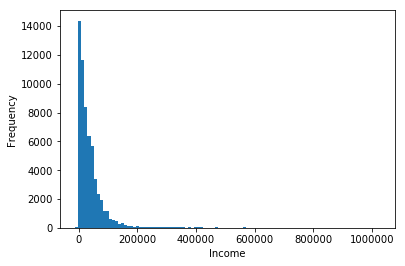

In [8]:
plt.xlabel('Income')
df.PINCP.plot.hist(bins=100)
plt.show()

Looking at a more detailed view of just income that is less than $150,000, we see what appears to be a peak somewhere around $10,000. Additionally, we see a huge number of of responses who claim to bring in an income of $0. Additional analysis be used to determine if these individuals have supplemted earnings from another source.

Next we take a look at the distribution of the person's age. It appears that the distribution is fairly uniform. We can see that there is a spike in responses from the baby boomers. Response frequencies tend to trail off after age 65 or so. Strangely, there is spike around age 92. Additional analysis should be done to determine if this spike is in  error.

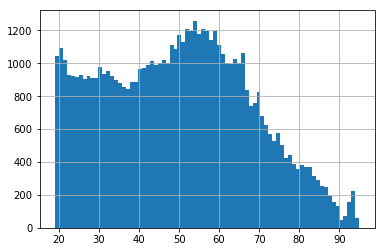

In [9]:
df.AGEP.hist(bins=len(df.AGEP.unique()))
plt.show()

Next, we look at commute time (`JWMNP`). Although one would expect this to be continuous, we find that there are many spikes in the datset.

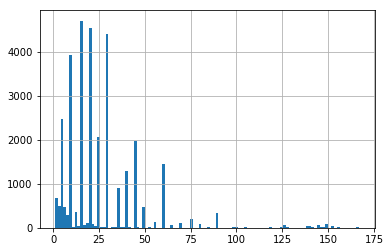

In [10]:
df.JWMNP.hist(bins=len(df.JWMNP.unique()))
plt.show()

Further analysis into cummute time, we can determine that these large spikes can be attributed to such approximations which are common when describing time in minutes:

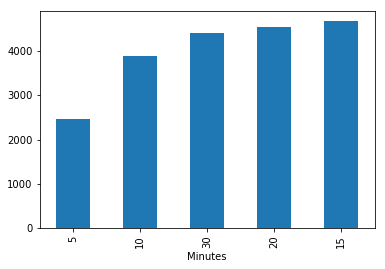

In [11]:
ax = df.JWMNP[df.JWMNP.notnull()].astype('int64').value_counts() \
    .sort_values().tail().plot(kind='bar')
ax.set_xlabel('Minutes')
plt.show()